<h1>目录<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#模型-(Model)" data-toc-modified-id="模型-(Model)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>模型 (Model)</a></span></li><li><span><a href="#训练算法-(Training-Algorithm)" data-toc-modified-id="训练算法-(Training-Algorithm)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>训练算法 (Training Algorithm)</a></span></li><li><span><a href="#加载数据-(Loading-Data)" data-toc-modified-id="加载数据-(Loading-Data)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>加载数据 (Loading Data)</a></span></li><li><span><a href="#数据模型-(Data-Model)" data-toc-modified-id="数据模型-(Data-Model)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>数据模型 (Data Model)</a></span></li><li><span><a href="#自监督学习-(Self-Supervised-Learning)" data-toc-modified-id="自监督学习-(Self-Supervised-Learning)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>自监督学习 (Self-Supervised Learning)</a></span><ul class="toc-item"><li><span><a href="#结果示例-(Representative-Results)" data-toc-modified-id="结果示例-(Representative-Results)-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>结果示例 (Representative Results)</a></span></li></ul></li><li><span><a href="#只使用带标签数据-(Using-Only-Labeled-Samples)" data-toc-modified-id="只使用带标签数据-(Using-Only-Labeled-Samples)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>只使用带标签数据 (Using Only Labeled Samples)</a></span><ul class="toc-item"><li><span><a href="#结果示例-(Representative-Results)" data-toc-modified-id="结果示例-(Representative-Results)-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>结果示例 (Representative Results)</a></span></li></ul></li><li><span><a href="#保存模型-(Save-Model)" data-toc-modified-id="保存模型-(Save-Model)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>保存模型 (Save Model)</a></span></li></ul></div>

# 模型 (Model)

In [2]:
import torch 
import torch.nn as nn
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self,class_num=45):
        super(ConvNet, self).__init__()
                
        self.convs = nn.Sequential(          #99*99
            nn.Conv2d(1,48, kernel_size=5, stride=1, padding=2), #99*99
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  #49*49
            
            nn.Conv2d(48, 48, kernel_size=5, stride=2, padding=2), #25*25
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride=2), #12*12
           
        )
        
        
        self.convs_red = nn.Sequential(          #99*99
            nn.MaxPool2d(kernel_size=6, stride=5, padding=1),  #20*20
            
            nn.Conv2d(1,32, kernel_size=6, stride=2, padding=3), #11*11
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.AvgPool2d(kernel_size=3, stride=2), #5*5
        )
        
        self.convs_grad = nn.Sequential(          #99*99
            nn.Conv2d(1,48, kernel_size=5, stride=1, padding=2), #99*99
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  #49*49
            
            nn.Conv2d(48, 48, kernel_size=5, stride=2, padding=2), #25*25
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride=2), #12*12
        )
        
        self.fc_ratio = nn.Sequential(
            nn.Linear(1, 512),
            nn.Sigmoid()
        )
              
               
        self.fc = nn.Sequential(
            nn.Linear(12*12*48+5*5*32+12*12*48+512, class_num),
            nn.Sigmoid(),
            #nn.Linear(64, class_num),
        )
   
           
    def forward(self, x, r):
        y1 = self.convs(x[:,[1],:,:])
        y1 = y1.view(y1.size(0), -1)
        
        
        y2 = self.convs_red(x[:,[0],:,:])
        y2 = y2.view(y2.size(0), -1)
        
        y3 = self.convs_grad(x[:,[2],:,:])
        y3 = y3.view(y3.size(0), -1)
        
        y4 = self.fc_ratio(r)
        
        ya = torch.cat((y1,y2,y3,y4),1)
        
        out = self.fc(ya)
        #out2 = self.fc_red(out_red1.view(out_red1.size(0),-1))*0
             
        
        return out

# 训练算法 (Training Algorithm)

In [19]:
from tqdm import tqdm_notebook as tqdm

def train(model,label_dataset,unlabel_dataset,eval_loader,criterion,optimizer,num_epochs,device,state):
    model.train()
    
    trn_loss = []
    val_loss = []
    
    stop_ctr = 0
    
    for epoch in range(num_epochs):
        ims,ras,lbs,ws = label_dataset.get_pairs()
        #predict unlabel label
        if unlabel_dataset is not None and epoch>state['init_label_epoch']:
            u_ims,u_ras,u_lbs,u_ws = unlabel_dataset.get_pairs(model,device)
            
            ims = torch.cat((ims,u_ims),0)
            ras = torch.cat((ras,u_ras),0)
            lbs = torch.cat((lbs,u_lbs),0)
            ws = torch.cat((ws,u_ws),0)
        
        dataset = torch.utils.data.TensorDataset(ims,ras,lbs,ws)
                                              
        loader = torch.utils.data.DataLoader(dataset=dataset,
                                             batch_size=100, 
                                             shuffle=True)

        tloss = one_epoch(model,loader,criterion,optimizer,device)

        vloss = val(model,eval_loader,criterion,device)

        print ('\rEpoch [{}/{}],  Loss: {:.4f}/{:.4f} ' 
                   .format(epoch+1, num_epochs, tloss, vloss))

        trn_loss.append(tloss)
        val_loss.append(vloss)
        
        if epoch>state['min_epoch']:
            if vloss<state["best_score"]:
                stop_ctr = 0
                state['best_score'] = vloss
                checkpoint = {
                        'state_dict': model.state_dict(),
                        'state': state
                }
                torch.save(checkpoint, state['save_path'])
            else:
                stop_ctr+=1
                if stop_ctr>state['max_stop']:
                    break
                
    return np.array(trn_loss),np.array(val_loss)

def one_epoch(model,loader,criterion,optimizer,device):
    
    losses = []
    
    for (images,ratios,labels,weights) in loader:
        images = images.to(device)
        ratios = ratios.to(device)
        labels = labels.to(device)
        weights = weights.to(device)

        optimizer.zero_grad()
        outputs = model(images,ratios)
        loss = criterion(outputs, labels, weights)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())

    return np.mean(losses)
    
# Test the model
def val(model,valLoader,criterion,device):
    with torch.no_grad():
        losses = []
        for (images,ratios,labels,_) in valLoader:
            images = images.to(device)
            ratios = ratios.to(device)
            labels = labels.to(device)
            
            ws = torch.ones((images.shape[0],1),dtype=torch.float32).to(device)
            
            outputs = model(images,ratios)
            loss = criterion(outputs, labels, ws)
            
            losses.append(loss.item())
        
        return np.mean(losses)

# Test the model
def test(model,loader,device):
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
                
        gt = []
        pr = []
        
        if type(loader) is not list:
            loader = [loader]
        
        for i,tl in enumerate(loader):
                        
            gt.append([])
            pr.append([])
            for (images,ratios,_,angles) in tl:
                images = images.to(device)
                ratios = ratios.to(device)
                
                outputs = model(images,ratios)
                
                gt[-1].append(angles.numpy())
                pr[-1].append(outputs.detach().cpu().numpy())

            gt[-1] = np.concatenate(gt[-1],axis=0)
            pr[-1] = np.concatenate(pr[-1],axis=0)
        
        pr = np.stack(pr,axis=2)
        
        pr_max = np.max(pr,axis=1,keepdims=True)
        #pr = pr/pr_max
        
        pr_mean = np.mean(pr,axis=2)
        
        gt = np.squeeze(gt[0])
        
        pr_a = np.zeros(np.size(pr,0),dtype=np.float32)
        for i in range(np.size(pr,0)):
            pr_a[i] = label2angle(pr_mean[i,:])
            
        angle_error = np.abs(gt-pr_a)
        angle_error = np.min(np.vstack((360-angle_error,angle_error)),axis=0)

        return gt,pr,np.mean(angle_error)
    

In [1]:
import numpy as np

class_num = 360
idx = np.arange(-180,180).astype(np.float32)

pdf = np.exp(-np.power(idx,2)/160).astype(np.float32)
pdf = np.hstack((pdf[180:],pdf[:180]))

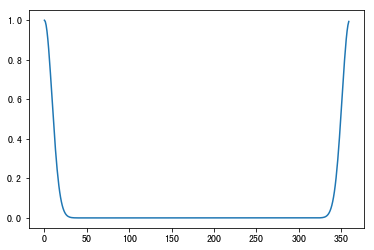

In [3]:
import matplotlib.pyplot as plt

plt.plot(pdf)
plt.show()

In [4]:
def angle2label(ag,pdf):
    
    ag = int(np.around(ag))
    ag = np.mod(ag,360)
    
    assert 360==len(pdf)
        
    label = np.hstack((pdf[360-ag:],pdf[:360-ag]))
    
    return label
    
        
        
def label2angle(lb):
    
    return np.argmax(lb)
    
    
    

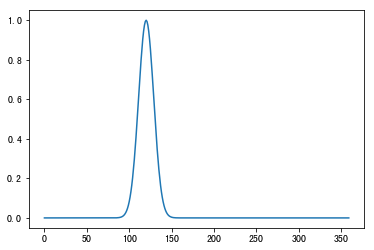

In [5]:
lb = angle2label(120,pdf)
plt.plot(lb)
plt.show()

In [7]:
pdf.shape,idx.shape,label2angle(angle2label(380,pdf))

((360,), (360,), 20)

# 加载数据 (Loading Data)

In [8]:
import pickle
import numpy as np


with open('data/gray_aug_unlabel_data.dat','rb') as f:
    data = pickle.load(f)
    

In [9]:
import torch 

#labeled data
label_x = []
label_r = []
label_a = []
label_l = []
for item in data['label']:
    im = np.stack(item['im'],axis=0) #n*h*w*c
    ra = np.vstack(item['ra']) #n*1
    ag = np.vstack(item['ag']) #n*1
    lb = np.vstack([angle2label(a,pdf) for a in item['ag']]) #n*360
    
    label_x.append(im) #N * n*h*w*c
    label_r.append(ra) 
    label_a.append(ag)
    label_l.append(lb)
    
label_x = np.concatenate(label_x,axis=0) #N*h*w*c
label_r = np.concatenate(label_r,axis=0) #N*1
label_a = np.concatenate(label_a,axis=0) #N*1
label_l = np.concatenate(label_l,axis=0) #N*360

#unlabeled data
#eval data
aug_num = len(data['test'][0]['im'])
unlabel_x = []
unlabel_r = []
unlabel_a = []
unlabel_l = []

eval_x = []
eval_r = []
eval_a = []
eval_l = []
for i in range(aug_num):
    for seq in data['unlabel']:
        seq_x = []
        seq_r = []
        seq_a = []
        seq_l = []
        for item in seq:
            im = item['im'][i] #h*w*c
            ra = item['ra'][i] #n*1
            ag = item['ag'][i] #n*360
            lb = angle2label(ag,pdf) #n*360

            seq_x.append(im) #N * n*h*w*c
            seq_r.append(ra) 
            seq_a.append(ag)
            seq_l.append(lb)
    
        eval_x.append(seq_x[-1]) #每个序列的最后一个作为eval样本
        eval_r.append(seq_r[-1])
        eval_a.append(seq_a[-1])
        eval_l.append(seq_l[-1])
    
        seq_x = np.stack(seq_x[:-1],axis=0) #N*h*w*c
        seq_r = np.vstack(seq_r[:-1]) #N*1
        seq_a = np.vstack(seq_a[:-1]) #N*1
        seq_l = np.vstack(seq_l[:-1]) #N*360

        unlabel_x.append(seq_x) #[N*h*w*c]
        unlabel_r.append(seq_r)
        unlabel_a.append(seq_a)
        unlabel_l.append(seq_l)
        
eval_x = np.stack(eval_x) #N*h*w*c
eval_r = np.vstack(eval_r) #N*1
eval_a = np.vstack(eval_a) #N*1
eval_l = np.vstack(eval_l) #N*360
    
#test data
test_x = [[] for _ in range(aug_num)]
test_r = [[] for _ in range(aug_num)]
test_a = [[] for _ in range(aug_num)]
test_l = [[] for _ in range(aug_num)]

for i in range(aug_num):
    for item in data['test']:
        im = item['im'][i] #h*w*c
        ra = item['ra'][i] #n*1
        ag = item['ag'][i] #n*360
        lb = angle2label(ag,pdf) #n*360

        test_x[i].append(im) #N * h*w*c
        test_r[i].append(ra)
        test_a[i].append(ag)
        test_l[i].append(lb)

    test_x[i] = np.stack(test_x[i],axis=0) #N*h*w*c
    test_r[i] = np.vstack(test_r[i]) #N*1
    test_a[i] = np.vstack(test_a[i]) #N*360
    test_l[i] = np.vstack(test_l[i]) #N*360

In [10]:
eval_x.shape,unlabel_x[0].shape,len(unlabel_x)

((500, 100, 100, 3), (10, 100, 100, 3), 500)

In [11]:
#归一化
channel = label_x.shape[-1]
im_temp = np.concatenate(unlabel_x,axis=0)
print(f'im_temp: {im_temp.shape}')
im_temp = im_temp.reshape(-1,channel)

maxv = np.max(im_temp,axis=0)
minv = np.min(im_temp,axis=0)
meanv = np.mean(np.vstack((maxv,minv)),axis=0)

ra_temp = np.concatenate(unlabel_r,axis=0)
print(f'ratio_temp: {ra_temp.shape}')
max_r = np.max(ra_temp)
min_r = np.min(ra_temp)
mean_r = np.mean([max_r,min_r])
    
label_x = (label_x-meanv)/(maxv-minv)+0.5
label_x = torch.tensor(np.transpose(label_x,(0,3,1,2)),dtype=torch.float32)
label_r = 2*(label_r-mean_r)/(max_r-min_r)
label_r = torch.tensor(label_r,dtype=torch.float32)
label_a = torch.tensor(label_a,dtype=torch.float32)
label_l = torch.tensor(label_l,dtype=torch.float32)

eval_x = (eval_x-meanv)/(maxv-minv)+0.5
eval_x = torch.tensor(np.transpose(eval_x,(0,3,1,2)),dtype=torch.float32)
eval_r = 2*(eval_r-mean_r)/(max_r-min_r)
eval_r = torch.tensor(eval_r,dtype=torch.float32)
eval_a = torch.tensor(eval_a,dtype=torch.float32)
eval_l = torch.tensor(eval_l,dtype=torch.float32)

for i in range(len(unlabel_x)):
    unlabel_x[i] = (unlabel_x[i]-meanv)/(maxv-minv)+0.5
    unlabel_x[i] = torch.tensor(np.transpose(unlabel_x[i],(0,3,1,2)),dtype=torch.float32)
    unlabel_r[i] = 2*(unlabel_r[i]-mean_r)/(max_r-min_r)
    unlabel_r[i] = torch.tensor(unlabel_r[i],dtype=torch.float32)
    unlabel_a[i] = torch.tensor(unlabel_a[i],dtype=torch.float32)
    unlabel_l[i] = torch.tensor(unlabel_l[i],dtype=torch.float32)


for i in range(len(test_x)):
    test_x[i] = (test_x[i]-meanv)/(maxv-minv)+0.5
    test_x[i] = torch.tensor(np.transpose(test_x[i],(0,3,1,2)),dtype=torch.float32)
    test_a[i] = torch.tensor(test_a[i],dtype=torch.float32)
    test_l[i] = torch.tensor(test_l[i],dtype=torch.float32)
    
    test_r[i] = 2*(test_r[i]-mean_r)/(max_r-min_r)
    test_r[i] = torch.tensor(test_r[i],dtype=torch.float32)

im_temp: (6945, 100, 100, 3)
ratio_temp: (6945, 1)


In [12]:
meanv,maxv,minv,mean_r,max_r,min_r

(array([0.49346405, 0.5       , 0.39024738]),
 array([0.9869281 , 1.        , 0.78049476]),
 array([0., 0., 0.]),
 0.6667455874158426,
 1.0024074205197195,
 0.33108375431196563)

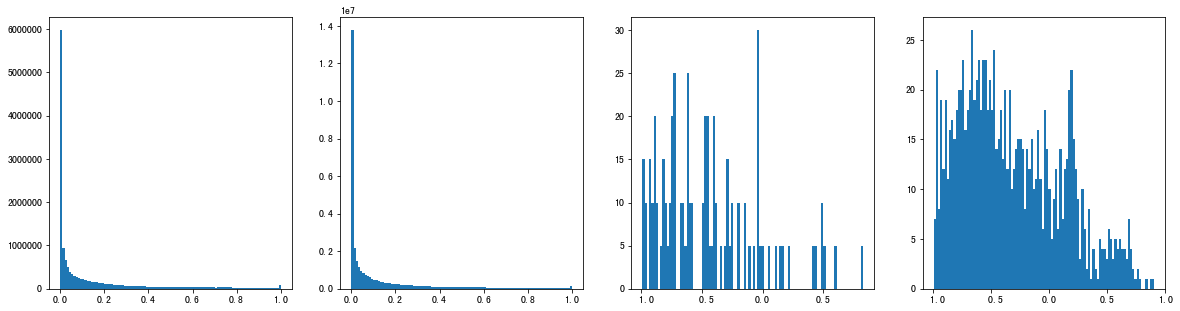

In [13]:
_,axes = plt.subplots(ncols=4,figsize=(20,5))
axes[0].hist(eval_x.view(-1),bins=100)
axes[1].hist(test_x[0].view(-1),bins=100)
axes[2].hist(eval_r.view(-1),bins=100)
axes[3].hist(test_r[0].view(-1),bins=100)
plt.show()

In [14]:
label_x.shape,label_l.shape,label_r.shape,label_a.shape

(torch.Size([615, 3, 100, 100]),
 torch.Size([615, 360]),
 torch.Size([615, 1]),
 torch.Size([615, 1]))

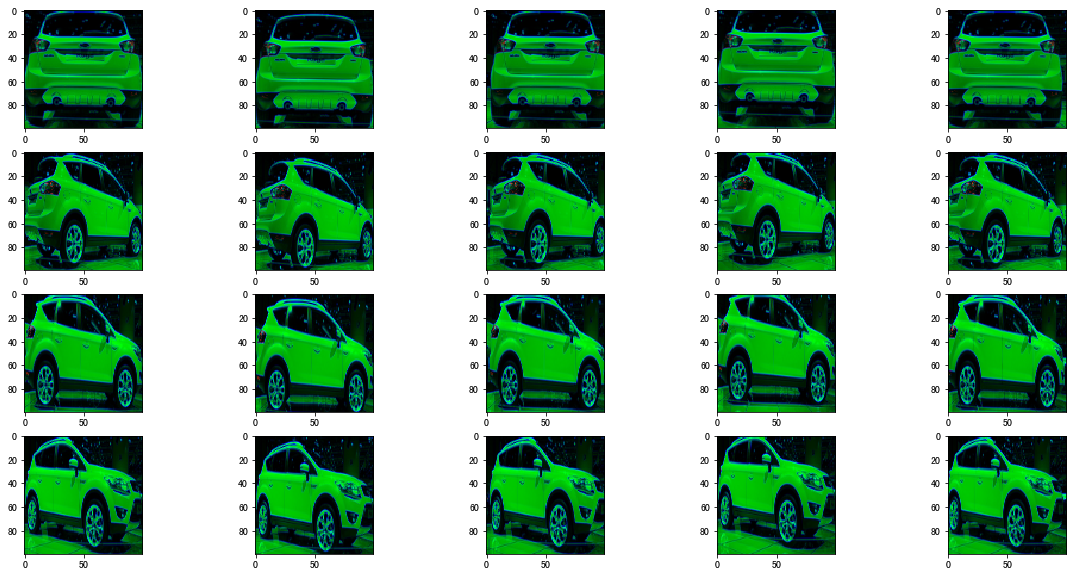

tensor([[176.3758],
        [176.3758],
        [176.3758],
        [176.3758],
        [176.3758],
        [227.1141],
        [227.1141],
        [227.1141],
        [227.1141],
        [227.1141],
        [263.3557],
        [263.3557],
        [263.3557],
        [263.3557],
        [263.3557],
        [304.4295],
        [304.4295],
        [304.4295],
        [304.4295],
        [304.4295]])


In [15]:
import matplotlib.pyplot as plt

figures,axes = plt.subplots(nrows=4,ncols=5,figsize=(20,10))

for i,ax in enumerate(axes.reshape(20)):
    if label_x.size(1)==3:
        ax.imshow(label_x[i,:,:,:].permute((1,2,0)))
    else:
        ax.imshow(label_x[i,1,:,:])

plt.show()
print(label_a[:20,:]) 

# 数据模型 (Data Model)

In [39]:
def weighted_mse_loss(x, y, w):
    n = x.shape[0]
    return torch.sum(w * (x - y) ** 2)/n

class LabelDataset(object):
    def __init__(self,lx,lr,ll,la):
        super(LabelDataset, self).__init__()
        self.lx = lx
        self.lr = lr
        self.ll = ll
        self.la = la
        
    def get_pairs(self):
        return self.lx,self.lr,self.ll,torch.ones((self.lx.shape[0],1),dtype=torch.float32)

class UnlabelDataset(object):
    def __init__(self,ux,ur,ua,weight):
        super(UnlabelDataset, self).__init__()
        self.ux = ux
        self.ur = ur
        self.ua = ua
        self.weight = weight
        
        self.xc = []
        self.rc = []
        self.ac = []
        for x,r,a in zip(self.ux,self.ur,self.ua):
            self.xc.append(x[0,:,:,:])
            self.xc.append(x[-1,:,:,:])
            self.rc.append(r[0,:])
            self.rc.append(r[-1,:])
            self.ac.append(a[0,:])
            self.ac.append(a[-1,:])
            
        self.xc = torch.stack(self.xc,0)
        self.rc = torch.stack(self.rc,0)
        self.ac = torch.stack(self.ac,0)
        
    def predict(self,model,loader,device):
        
        with torch.no_grad():

            pr = []
            
            for (images,ratios) in loader:
                images = images.to(device)
                ratios = ratios.to(device)

                outputs = model(images,ratios)

                pr.append(outputs.detach().cpu().numpy())

            pr = np.concatenate(pr,axis=0)

            pr_a = np.zeros(np.size(pr,0),dtype=np.float32)
            for i in range(np.size(pr,0)):
                pr_a[i] = label2angle(pr[i,:])

            return pr_a

    def get_gt_pr(self,model,device):
        dataset = torch.utils.data.TensorDataset(self.xc,
                                            self.rc,
                                            torch.zeros((self.xc.shape[0],1),dtype=torch.float32),
                                            self.ac)


        ldr = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=100, 
                                          shuffle=False)
        
        return test(model,ldr,device)
        
        
    def get_ends(self):
        return self.xc,self.rc
    
    def get_pairs(self,model,device):
        dataset = torch.utils.data.TensorDataset(self.xc,
                                            self.rc
                                            )


        ldr = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=100, 
                                          shuffle=False)
        
        preds = self.predict(model,ldr,device)
            
        preds = preds.reshape(-1,2)
        
        assert preds.shape[0] == len(self.ux)
        
        nlbs = []
        for i,x in enumerate(self.ux):
            lbs = self.generate_new_labels(preds[i,:],x.shape[0])
            nlbs.append(lbs)
            
        xs = np.concatenate(self.ux,axis=0)
        rs = np.concatenate(self.ur,axis=0)
        ys = np.concatenate(nlbs,axis=0)
        
        xs = torch.tensor(xs)
        rs = torch.tensor(rs)
        ys = torch.tensor(ys)
        
        return xs,rs,ys,torch.ones((xs.shape[0],1),dtype=torch.float32)*self.weight
            
    def generate_new_labels(self,angle_ends,num):
        ag1,ag2 = angle_ends[0],angle_ends[1]
        ag2 = ag2 if ag2>ag1 else ag2+360

        ags = np.linspace(ag1,ag2,num)
        ags = np.mod(ags,360)

        lbs = np.vstack([angle2label(l,pdf) for l in ags])

        return lbs
            

In [112]:
import torch.utils.data
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# Hyper parameters
num_epochs = 20
batch_size = 100

# MNIST dataset
label_dataset = LabelDataset(label_x,
                             label_r,
                             label_l,
                             label_a)

eval_dataset = torch.utils.data.TensorDataset(eval_x,
                                              eval_r,
                                              eval_l,
                                              eval_a)


eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

unlabel_dataset = UnlabelDataset(unlabel_x,
                                unlabel_r,
                                unlabel_a,
                                0.05)

test_dataset = []
test_loader = []
for i in range(len(test_x)):
    test_dataset.append(torch.utils.data.TensorDataset(test_x[i],
                                                       test_r[i],
                                                       test_l[i],
                                                       test_a[i]))
    
    test_loader.append(torch.utils.data.DataLoader(dataset=test_dataset[i],
                                                   batch_size=batch_size, 
                                                   shuffle=False))



# 自监督学习 (Self-Supervised Learning)

In [113]:
state = {'init_lr':0.001,
         'lr':1,
         'reset_epoch':1000,
         'max_stop':2,
         'min_epoch':10,
         'init_label_epoch':10,
         'unlabel_w':0.001,
         'wd':0,
         'min_lr':1e-5,
         'best_score':100,
         'save_path':'model/ck.mdl'}

model = ConvNet(class_num=class_num).to(device)
#model.apply(init_weights)
# Loss and optimizer
criterion = weighted_mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

In [114]:
lab_loss,val_loss = train(model,
                          label_dataset,unlabel_dataset,eval_loader,
                          criterion,optimizer,100,device,state)


Epoch [1/100],  Loss: 30.7778/14.8083 
Epoch [2/100],  Loss: 15.1687/15.4949 
Epoch [3/100],  Loss: 15.5613/15.6425 
Epoch [4/100],  Loss: 15.6520/15.6841 
Epoch [5/100],  Loss: 15.6762/15.6938 
Epoch [6/100],  Loss: 15.6773/15.6885 
Epoch [7/100],  Loss: 15.6631/15.6721 
Epoch [8/100],  Loss: 15.6346/15.6426 
Epoch [9/100],  Loss: 15.5426/15.6017 
Epoch [10/100],  Loss: 15.4793/15.5338 
Epoch [11/100],  Loss: 15.2191/15.4675 
Epoch [12/100],  Loss: 1.8786/15.2180 
Epoch [13/100],  Loss: 1.7756/15.2059 
Epoch [14/100],  Loss: 1.6909/14.7178 
Epoch [15/100],  Loss: 1.5952/13.4617 
Epoch [16/100],  Loss: 1.4016/11.4807 
Epoch [17/100],  Loss: 1.0495/8.6625 
Epoch [18/100],  Loss: 0.7036/6.5763 
Epoch [19/100],  Loss: 0.4944/5.4442 
Epoch [20/100],  Loss: 0.3709/4.7760 
Epoch [21/100],  Loss: 0.3071/4.3388 
Epoch [22/100],  Loss: 0.2526/4.0691 
Epoch [23/100],  Loss: 0.2181/3.8041 
Epoch [24/100],  Loss: 0.2024/3.5993 
Epoch [25/100],  Loss: 0.1899/3.4907 
Epoch [26/100],  Loss: 0.1817/3.

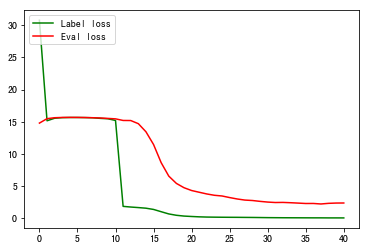

In [115]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(lab_loss,label='Label loss',color='green')
ax1.plot(val_loss,label='Eval loss',color='red')
ax1.legend(loc='upper left')
plt.show()

In [116]:
model.load_state_dict(torch.load(state['save_path'])['state_dict'])
gt,prs,_ = test(model,test_loader,device)

gt = np.squeeze(gt)
pr = np.mean(prs,axis=2)

pr_a = np.zeros(np.size(pr,0),dtype=np.float32)

for i in range(np.size(pr,0)):
    pr_a[i] = label2angle(pr[i,:])

angle_error = np.abs(gt-pr_a)

angle_error = np.min(np.vstack((360-angle_error,angle_error)),axis=0)

n160 = np.where(angle_error>140)

print(f'mean:{np.mean(angle_error)}, median:{np.median(angle_error)},n160:{len(n160[0])}')

mean:12.023420333862305, median:3.6548690795898438,n160:29


[174.27272 174.72728 175.      175.      175.57523 175.85715 176.
 178.      179.5     179.71428]


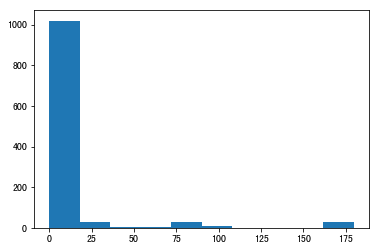

In [117]:
angle_sort = np.sort(angle_error)
print(angle_sort[-10:])

plt.hist(angle_error)
plt.show()

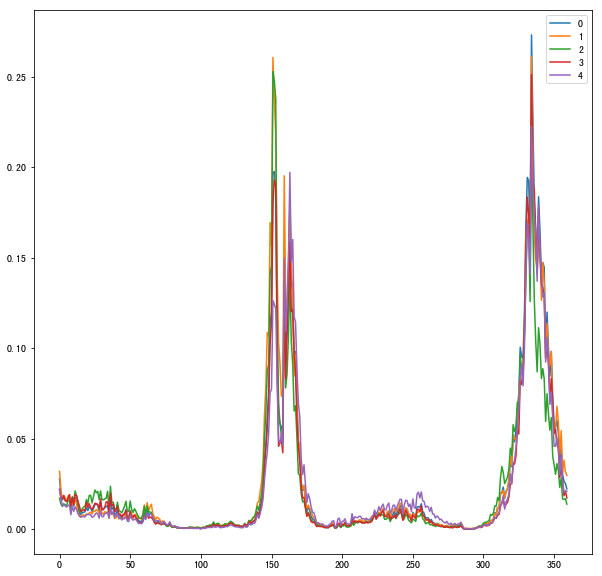

true:154.2857208251953,pred:334.0


In [118]:
idx = np.argsort(angle_error)

plt.figure(figsize=(10,10))

lid = -1

for i in range(np.size(prs,2)):
    plt.plot(prs[idx[lid],:,i], label=f'{i}')

plt.legend(loc='upper right')
plt.show()

print(f'true:{gt[idx[lid]]},pred:{pr_a[idx[lid]]}')

## 结果示例 (Representative Results)

In [119]:
import pickle
import numpy as np

with open('data/rgb_data.dat','rb') as f:
    data_rgb = pickle.load(f)

In [120]:
img_rgb = []
gt_rgb = []
pr_rgb = []

idc = 0
for i in range(10,20):
    imseq = data_rgb['images'][i]
    num = len(imseq)
    ide = idc+num
    img_rgb.append(np.stack(imseq,axis=0))
    gt_rgb.append(np.hstack(data_rgb['angles'][i]))
    pr_rgb.append(pr_a[idc:ide])
    
    idc = ide
    

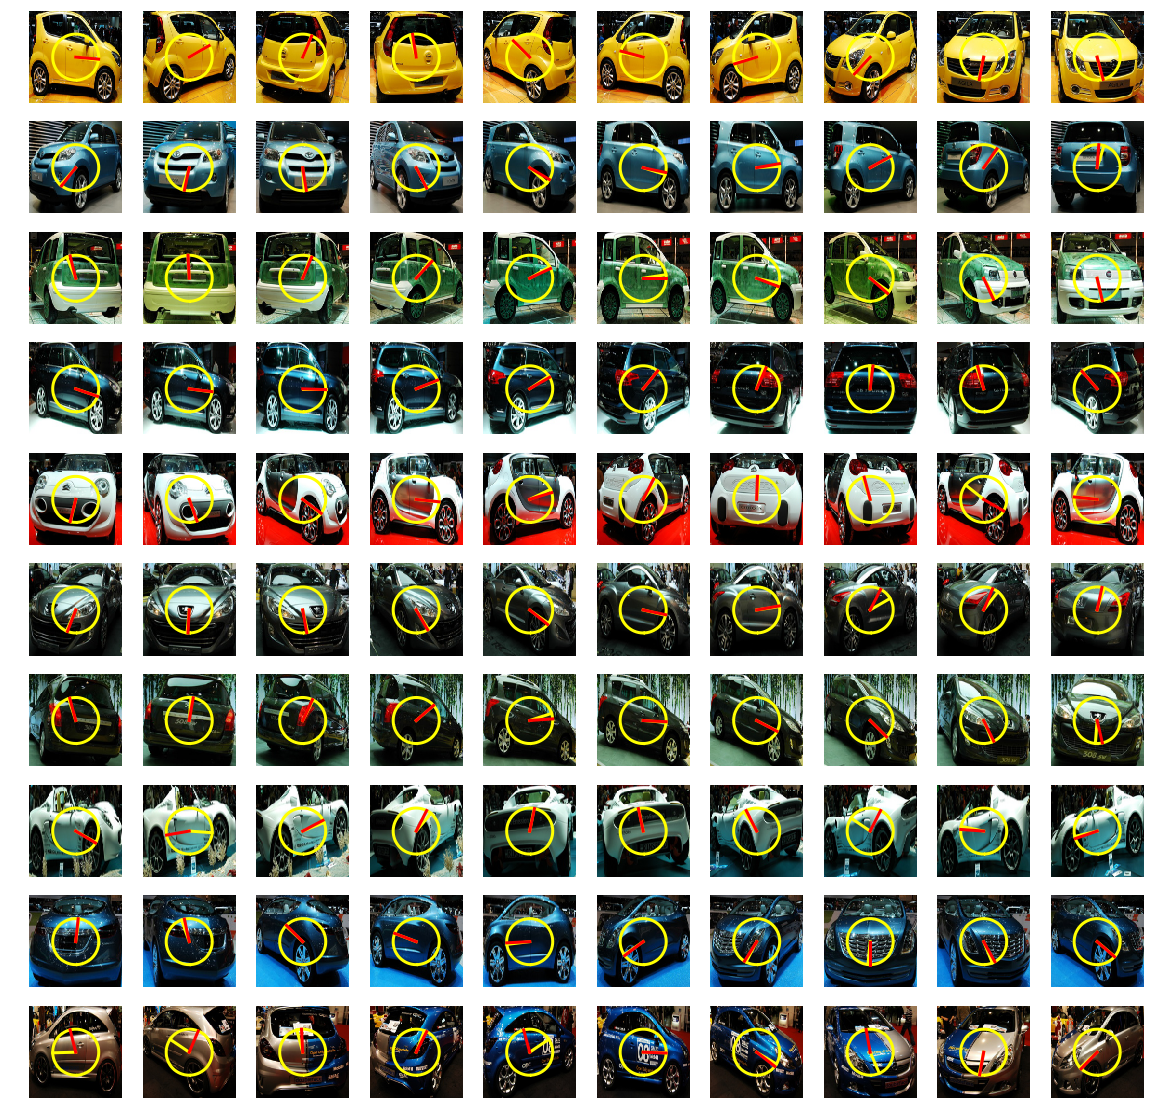

In [122]:
_,axes = plt.subplots(ncols =10,nrows=10,figsize=(20,20))

ww = test_dataset[0][0][0].shape[1]/2

t = np.arange(0,2*np.pi,0.1)
cir = np.vstack((-ww/2*np.sin(t)+ww,ww/2*np.cos(t)+ww))

for i in range(10):
    for j in range(10):
        
        im = img_rgb[i][j*7]
        axes[i][j].imshow(im)

        axes[i][j].plot(cir[0,:],cir[1,:],color='yellow',lw='3')

        ang_true = gt_rgb[i][j*7]
        ang_pred = pr_rgb[i][j*7]

        x1,y1,x2,y2 = ww,ww,-ww/2*np.sin(np.deg2rad(ang_true))+ww,ww/2*np.cos(np.deg2rad(ang_true))+ww
        axes[i][j].plot([x1,x2],[y1,y2],color="yellow",lw='3')

        x1,y1,x2,y2 = ww,ww,-ww/2*np.sin(np.deg2rad(ang_pred))+ww,ww/2*np.cos(np.deg2rad(ang_pred))+ww
        axes[i][j].plot([x1,x2],[y1,y2],color="red",lw='3')

        axes[i][j].axis('off')

plt.show()


# 只使用带标签数据 (Using Only Labeled Samples)

In [69]:
state = {'init_lr':0.001,
         'lr':1,
         'reset_epoch':1000,
         'max_stop':2,
         'min_epoch':10,
         'init_label_epoch':10,
         'unlabel_w':0.001,
         'wd':0,
         'min_lr':1e-5,
         'best_score':100,
         'save_path':'model/ck.mdl'}

model = ConvNet(class_num=class_num).to(device)
#model.apply(init_weights)
# Loss and optimizer
criterion = weighted_mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

In [70]:
lab_loss,val_loss = train(model,
                          label_dataset,None,eval_loader,
                          criterion,optimizer,100,device,state)


Epoch [1/100],  Loss: 30.8702/14.7565 
Epoch [2/100],  Loss: 15.1215/15.4635 
Epoch [3/100],  Loss: 15.5305/15.6210 
Epoch [4/100],  Loss: 15.6277/15.6657 
Epoch [5/100],  Loss: 15.6530/15.6755 
Epoch [6/100],  Loss: 15.6490/15.6684 
Epoch [7/100],  Loss: 15.6202/15.6450 
Epoch [8/100],  Loss: 15.5754/15.6038 
Epoch [9/100],  Loss: 15.4864/15.5338 
Epoch [10/100],  Loss: 15.3742/15.4642 
Epoch [11/100],  Loss: 15.1067/15.3830 
Epoch [12/100],  Loss: 14.9203/15.2411 
Epoch [13/100],  Loss: 14.5645/15.0756 
Epoch [14/100],  Loss: 14.3599/14.8879 
Epoch [15/100],  Loss: 13.6321/14.6131 
Epoch [16/100],  Loss: 12.9777/14.4104 
Epoch [17/100],  Loss: 12.4917/14.0419 
Epoch [18/100],  Loss: 11.9063/13.5056 
Epoch [19/100],  Loss: 11.1192/12.9896 
Epoch [20/100],  Loss: 10.4861/12.4057 
Epoch [21/100],  Loss: 9.6300/11.7479 
Epoch [22/100],  Loss: 8.5714/11.0593 
Epoch [23/100],  Loss: 7.5441/10.3364 
Epoch [24/100],  Loss: 7.0682/9.5578 
Epoch [25/100],  Loss: 5.8960/8.7874 
Epoch [26/100], 

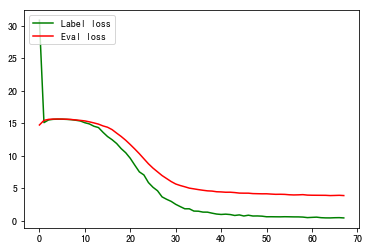

In [71]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(lab_loss,label='Label loss',color='green')
ax1.plot(val_loss,label='Eval loss',color='red')
ax1.legend(loc='upper left')
plt.show()

In [72]:
model.load_state_dict(torch.load(state['save_path'])['state_dict'])
gt,prs,_ = test(model,test_loader,device)

gt = np.squeeze(gt)
pr = np.mean(prs,axis=2)

pr_a = np.zeros(np.size(pr,0),dtype=np.float32)

for i in range(np.size(pr,0)):
    pr_a[i] = label2angle(pr[i,:])

angle_error = np.abs(gt-pr_a)

angle_error = np.min(np.vstack((360-angle_error,angle_error)),axis=0)

n160 = np.where(angle_error>140)

print(f'mean:{np.mean(angle_error)}, median:{np.median(angle_error)},n160:{len(n160[0])}')

mean:17.21758270263672, median:4.779354095458984,n160:50


[178.61539 178.71428 179.06897 179.09091 179.28572 179.42857 179.46155
 179.54546 179.82759 179.85715]


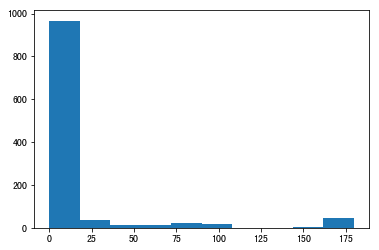

In [73]:
angle_sort = np.sort(angle_error)
print(angle_sort[-10:])

plt.hist(angle_error)
plt.show()

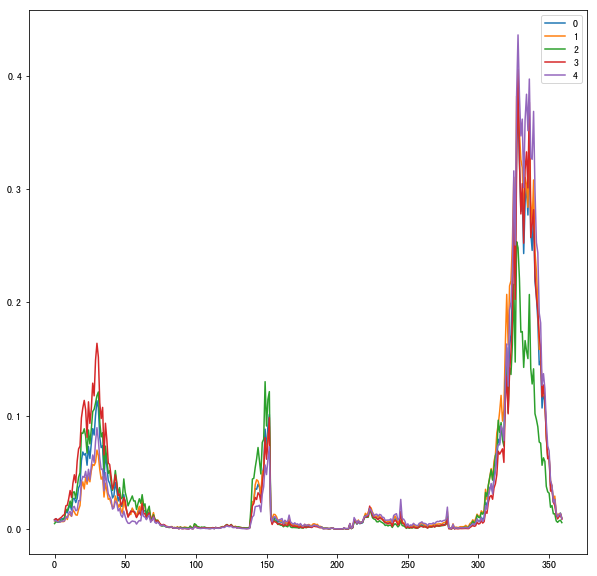

true:147.85714721679688,pred:328.0


In [74]:
idx = np.argsort(angle_error)

plt.figure(figsize=(10,10))

lid = -1

for i in range(np.size(prs,2)):
    plt.plot(prs[idx[lid],:,i], label=f'{i}')

plt.legend(loc='upper right')
plt.show()

print(f'true:{gt[idx[lid]]},pred:{pr_a[idx[lid]]}')

## 结果示例 (Representative Results)

In [75]:
import pickle
import numpy as np

with open('data/rgb_data.dat','rb') as f:
    data_rgb = pickle.load(f)

In [76]:
img_rgb = []
gt_rgb = []
pr_rgb = []

idc = 0
for i in range(10,20):
    imseq = data_rgb['images'][i]
    num = len(imseq)
    ide = idc+num
    img_rgb.append(np.stack(imseq,axis=0))
    gt_rgb.append(np.hstack(data_rgb['angles'][i]))
    pr_rgb.append(pr_a[idc:ide])
    
    idc = ide
    

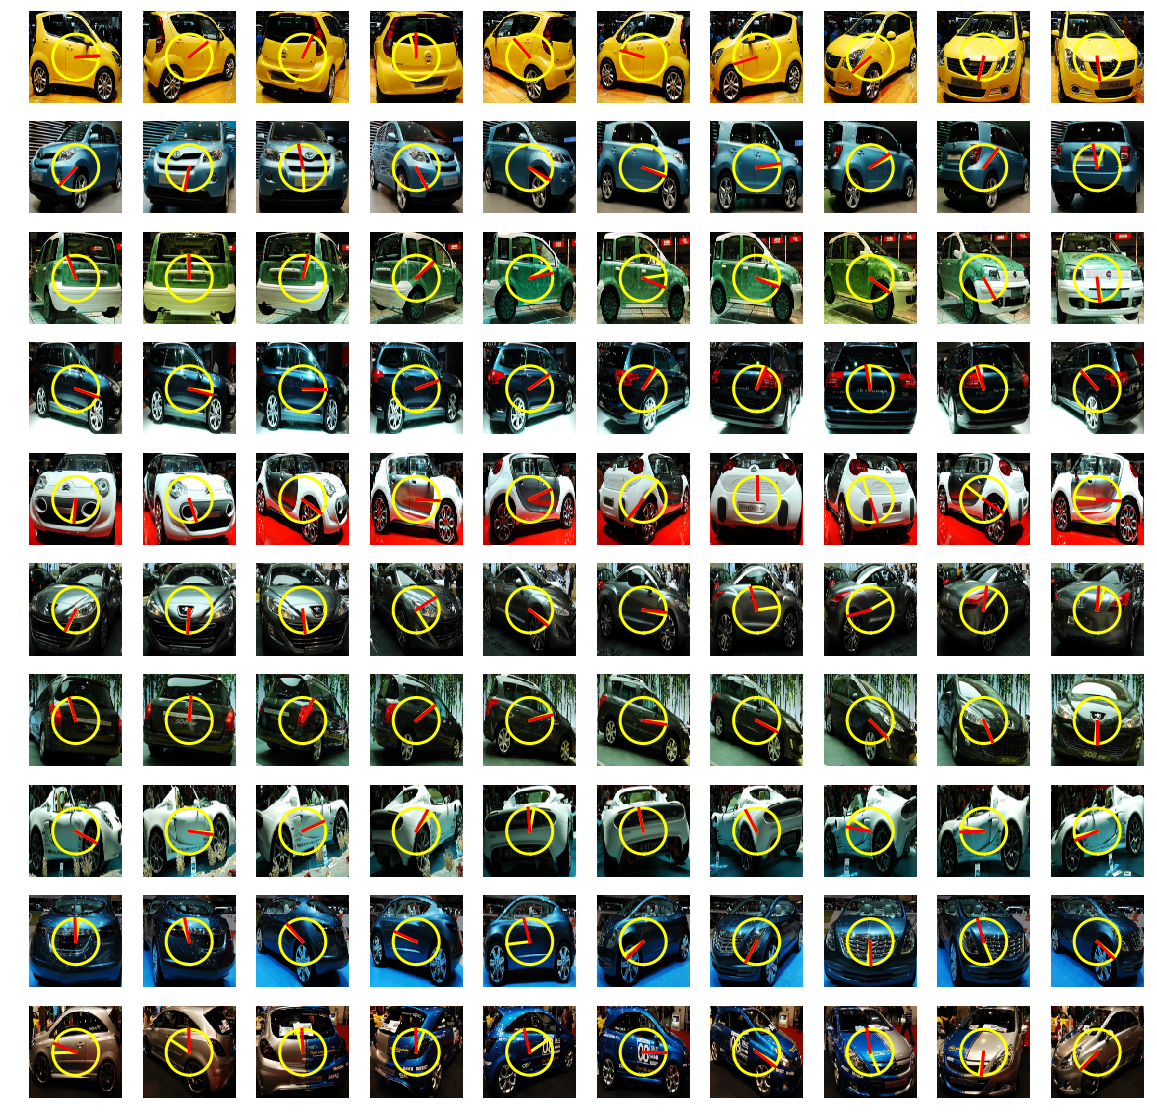

In [78]:
_,axes = plt.subplots(ncols =10,nrows=10,figsize=(20,20))

ww = test_dataset[0][0][0].shape[1]/2

t = np.arange(0,2*np.pi,0.1)
cir = np.vstack((-ww/2*np.sin(t)+ww,ww/2*np.cos(t)+ww))

for i in range(10):
    for j in range(10):
        
        im = img_rgb[i][j*7]
        axes[i][j].imshow(im)

        axes[i][j].plot(cir[0,:],cir[1,:],color='yellow',lw='3')

        ang_true = gt_rgb[i][j*7]
        ang_pred = pr_rgb[i][j*7]

        x1,y1,x2,y2 = ww,ww,-ww/2*np.sin(np.deg2rad(ang_true))+ww,ww/2*np.cos(np.deg2rad(ang_true))+ww
        axes[i][j].plot([x1,x2],[y1,y2],color="yellow",lw='3')

        x1,y1,x2,y2 = ww,ww,-ww/2*np.sin(np.deg2rad(ang_pred))+ww,ww/2*np.cos(np.deg2rad(ang_pred))+ww
        axes[i][j].plot([x1,x2],[y1,y2],color="red",lw='3')

        axes[i][j].axis('off')

plt.show()


# 保存模型 (Save Model)

In [ ]:
torch.save(model.state_dict(), 'model/best.mdl')